In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, adam

from cleverhans.attacks import fgsm, jsma
from cleverhans.utils_tf import model_train, model_eval, batch_eval
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes

import tensorflow as tf
from tensorflow.python.platform import flags

Using TensorFlow backend.


In [2]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC, LinearSVC

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [3]:
FLAGS = flags.FLAGS

flags.DEFINE_integer('nb_epochs', 20, 'Number of epochs to train model')
flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
flags.DEFINE_float('learning_rate', 0.1, 'Learning rate for training')
flags.DEFINE_integer('nb_classes', 5, 'Number of classification classes')
flags.DEFINE_integer('source_samples', 10, 'Nb of test set examples to attack')

In [4]:
names = ['duration', 'protocol', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
          'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
          'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
          'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
          'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
          'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
          'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
          'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'other']

df = pd.read_csv('KDDTrain+.txt', names=names, header=None)
dft = pd.read_csv('KDDTest+.txt', names=names, header=None)
print("Initial test and training data shapes:", df.shape[0], dft.shape[0])

full = pd.concat([df, dft])
assert full.shape[0] == df.shape[0] + dft.shape[0]

Initial test and training data shapes: 125973 22544


In [5]:
full['label'] = full['attack_type']

if FLAGS.nb_classes == 5:
    # DoS attacks
    full.loc[full.label == 'neptune', 'label'] = 'dos'
    full.loc[full.label == 'back', 'label'] = 'dos'
    full.loc[full.label == 'land', 'label'] = 'dos'
    full.loc[full.label == 'pod', 'label'] = 'dos'
    full.loc[full.label == 'smurf', 'label'] = 'dos'
    full.loc[full.label == 'teardrop', 'label'] = 'dos'
    full.loc[full.label == 'mailbomb', 'label'] = 'dos'
    full.loc[full.label == 'processtable', 'label'] = 'dos'
    full.loc[full.label == 'udpstorm', 'label'] = 'dos'
    full.loc[full.label == 'apache2', 'label'] = 'dos'
    full.loc[full.label == 'worm', 'label'] = 'dos'

    # User-to-Root (U2R)
    full.loc[full.label == 'buffer_overflow', 'label'] = 'u2r'
    full.loc[full.label == 'loadmodule', 'label'] = 'u2r'
    full.loc[full.label == 'perl', 'label'] = 'u2r'
    full.loc[full.label == 'rootkit', 'label'] = 'u2r'
    full.loc[full.label == 'sqlattack', 'label'] = 'u2r'
    full.loc[full.label == 'xterm', 'label'] = 'u2r'
    full.loc[full.label == 'ps', 'label'] = 'u2r'

    # Remote-to-Local (R2L)
    full.loc[full.label == 'ftp_write', 'label'] = 'r2l'
    full.loc[full.label == 'guess_passwd', 'label'] = 'r2l'
    full.loc[full.label == 'imap', 'label'] = 'r2l'
    full.loc[full.label == 'multihop', 'label'] = 'r2l'
    full.loc[full.label == 'phf', 'label'] = 'r2l'
    full.loc[full.label == 'spy', 'label'] = 'r2l'
    full.loc[full.label == 'warezclient', 'label'] = 'r2l'
    full.loc[full.label == 'warezmaster', 'label'] = 'r2l'
    full.loc[full.label == 'xlock', 'label'] = 'r2l'
    full.loc[full.label == 'xsnoop', 'label'] = 'r2l'
    full.loc[full.label == 'snmpgetattack', 'label'] = 'r2l'
    full.loc[full.label == 'httptunnel', 'label'] = 'r2l'
    full.loc[full.label == 'snmpguess', 'label'] = 'r2l'
    full.loc[full.label == 'sendmail', 'label'] = 'r2l'
    full.loc[full.label == 'named', 'label'] = 'r2l'

    # Probe attacls
    full.loc[full.label == 'satan', 'label'] = 'probe'
    full.loc[full.label == 'ipsweep', 'label'] = 'probe'
    full.loc[full.label == 'nmap', 'label'] = 'probe'
    full.loc[full.label == 'portsweep', 'label'] = 'probe'
    full.loc[full.label == 'saint', 'label'] = 'probe'
    full.loc[full.label == 'mscan', 'label'] = 'probe'

else:
    # Make this a binary classification task instead
    full.loc[full.label != 'normal', 'label'] = 'attack'

print(full.label.unique())
print(full.shape)

['normal' 'dos' 'r2l' 'probe' 'u2r']
(148517, 44)


In [6]:
full = full.drop(['other', 'attack_type'], axis=1)
print(full.shape)

(148517, 42)


In [7]:
if FLAGS.nb_classes == 5:

    full2 = pd.get_dummies(full, drop_first=False)

    features = list(full2.columns[:-5])

    y_train = full2[0:df.shape[0]][['label_normal', 'label_dos', 'label_probe', 'label_r2l', 'label_u2r']]
    X_train = full2[0:df.shape[0]][features]
    y_test = full2[df.shape[0]:][['label_normal', 'label_dos', 'label_probe', 'label_r2l', 'label_u2r']]
    X_test = full2[df.shape[0]:][features]
else:
    full2 = pd.get_dummies(full, drop_first=True)

    features = list(full2.columns[:-1])

    y_train = full2[0:df.shape[0]][['label_normal']]
    X_train = full2[0:df.shape[0]][features]
    y_test = full2[df.shape[0]:][['label_normal']]
    X_test = full2[df.shape[0]:][features]

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(125973, 122) (125973, 5)
(22544, 122) (22544, 5)


In [8]:
def mlp_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.6))
    if FLAGS.nb_classes == 5:
        model.add(Dense(FLAGS.nb_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='softmax'))
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
    model.summary()

    return model

In [9]:
def evaluate():
  eval_params = {'batch_size': FLAGS.batch_size}
  accuracy = model_eval(sess, x, y, predictions, X_test_scaled, y_test, args=eval_params)
  print('Test accuracy on legitimate test examples: ' + str(accuracy))


In [10]:
x = tf.placeholder(tf.float32, shape=(None, X_train_scaled.shape[1]))
if FLAGS.nb_classes == 5:
    y = tf.placeholder(tf.float32, shape=(None, FLAGS.nb_classes))
else:
    y = tf.placeholder(tf.float32, shape=(None, 1))

model = mlp_model()
sess = tf.Session()
predictions = model(x)
init = tf.global_variables_initializer()
sess.run(init)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               31488     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 98,565.0
Trainable params: 98,565.0
Non-trainable params: 0.0
_________________________________________________________________


In [12]:
# Train the model
train_params = {
        'nb_epochs': 30,
        'batch_size': FLAGS.batch_size,
        'learning_rate': FLAGS.learning_rate
    }
model_train(sess, x, y, predictions, X_train_scaled, y_train, evaluate=evaluate, args=train_params)

Epoch 0
	Epoch took 1.4403660297393799 seconds
Batch 100
Test accuracy on legitimate test examples: 0.729905961675
Epoch 1
	Epoch took 1.268531084060669 seconds
Batch 100
Test accuracy on legitimate test examples: 0.7232523066
Epoch 2
	Epoch took 1.2630383968353271 seconds
Batch 100
Test accuracy on legitimate test examples: 0.721788502484
Epoch 3
	Epoch took 1.439784049987793 seconds
Batch 100
Test accuracy on legitimate test examples: 0.720945706175
Epoch 4
	Epoch took 1.4369680881500244 seconds
Batch 100
Test accuracy on legitimate test examples: 0.719260113556
Epoch 5
	Epoch took 1.2376134395599365 seconds
Batch 100
Test accuracy on legitimate test examples: 0.719570617459
Epoch 6
	Epoch took 1.2382490634918213 seconds
Batch 100
Test accuracy on legitimate test examples: 0.723163591199
Epoch 7
	Epoch took 1.2852027416229248 seconds
Batch 100
Test accuracy on legitimate test examples: 0.725204045422
Epoch 8
	Epoch took 1.2504491806030273 seconds
Batch 100
Test accuracy on legitimate

True

In [11]:
source_samples = X_test_scaled.shape[0]
# Jacobian-based Saliency Map
results = np.zeros((FLAGS.nb_classes, source_samples), dtype='i')
perturbations = np.zeros((FLAGS.nb_classes, source_samples), dtype='f')
if FLAGS.nb_classes == 5:
    grads = jacobian_graph(predictions, x, FLAGS.nb_classes)
else:
    grads = jacobian_graph(predictions, x, 1)

X_adv = np.zeros((source_samples, X_test_scaled.shape[1]))

X_test_scaled1 = np.array(X_test_scaled)
y_test1 = np.array(y_test)


for sample_ind in range(0, source_samples):
    # We want to find an adversarial example for each possible target class
    # (i.e. all classes that differ from the label given in the dataset)
    current_class = int(np.argmax(y_test1[sample_ind]))
    # target_classes = other_classes(FLAGS.nb_classes, current_class)
    
    # for target in target_classes:
    for target in [0]:
        # print('--------------------------------------')
        # print('Creating adv. example for target class ' + str(target))
        if current_class == 0:
          break

        # This call runs the Jacobian-based saliency map approach
        adv_x, res, percent_perturb = jsma(sess, x, predictions, grads,
                                               X_test_scaled1[sample_ind: (sample_ind+1)],
                                               target, theta=1, gamma=0.1,
                                               increase=True, back='tf',
                                               clip_min=0, clip_max=1)
        X_adv[sample_ind] = adv_x
        #ind = np.where(X_adv != 0)[1]
        #print(ind, X_test.columns[ind], current_class)

        # Update the arrays for later analysis
        results[target, sample_ind] = res
        perturbations[target, sample_ind] = percent_perturb

print(X_adv.shape)

Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum nu

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Current iteration: 5 - Current Prediction: 0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum nu

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Current iteration: 5 - Current Prediction: 0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful
Maximum number of iterations: 6.0
Successful

In [12]:
eval_params = {'batch_size': FLAGS.batch_size}
accuracy = model_eval(sess, x, y, predictions, np.array(X_test_scaled), np.array(y_test),
                          args=eval_params)
print('Test accuracy on normal examples: ' + str(accuracy))

accuracy = model_eval(sess, x, y, predictions, X_adv, np.array(y_test),
                          args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Batch 100
Test accuracy on normal examples: 0.0428938963804
Batch 100
Test accuracy on adversarial examples: 0.430757629524


In [16]:
# Compute the number of adversarial examples that were successfuly found
# nb_targets_tried = ((FLAGS.nb_classes - 1) * FLAGS.source_samples)
#nb_targets_tried = FLAGS.source_samples
#succ_rate = float(np.sum(results)) / nb_targets_tried
#print('Avg. rate of successful adv. examples {0:.2f}'.format(succ_rate))

# Compute the average distortion introduced by the algorithm
#percent_perturbed = np.mean(perturbations[0, :])
#print('Avg. rate of perturbed features {0:.2f}'.format(percent_perturbed))

# Compute the average distortion introduced for successful samples only
#percent_perturb_succ = np.mean(perturbations[0, :] * (results == 1))
#print('Avg. rate of perturbed features for successful '
#         'adversarial examples {0:.2f}'.format(percent_perturb_succ))



In [13]:
score = model.evaluate(X_test_scaled1, np.array(y_test), verbose=0)
print('Test loss:', score[0])
print('Adversarial Test accuracy:', score[1])

score = model.evaluate(X_adv, np.array(y_test), verbose=0)
print('Test loss:', score[0])
print('Adversarial Test accuracy:', score[1])

# Close TF session
sess.close()

Test loss: 1.6681112535
Adversarial Test accuracy: 0.0428938963804
Test loss: 1.64249181265
Adversarial Test accuracy: 0.430757629524


In [14]:
if FLAGS.nb_classes == 5:
    dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
else:
    dt = DecisionTreeClassifier(random_state=99)
dt.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          n_jobs=1)

In [15]:
y_pred = dt.predict(X_test_scaled)

if FLAGS.nb_classes == 5:
    fpr_dt, tpr_dt, _ = roc_curve(y_test.values[:, 0], y_pred[:, 0])
else:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)

roc_auc_dt = auc(fpr_dt, tpr_dt)
print("Accuracy score", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy score 0.731902058197
F1 score: 0.727880177807


In [16]:
y_pred_adv = dt.predict(X_adv)

if FLAGS.nb_classes == 5:
    fpr_dt_adv, tpr_dt_adv, _ = roc_curve(y_test.values[:, 0], y_pred_adv[:, 0])
else:
    fpr_dt_adv, tpr_dt_adv, _ = roc_curve(y_test, y_pred_adv)

roc_auc_dt_adv = auc(fpr_dt_adv, tpr_dt_adv)
print("Adversarial test accuracy", accuracy_score(y_test, y_pred_adv))
print("F1 score:", f1_score(y_test, y_pred_adv, average='micro'))

Adversarial test accuracy 0.613600070972
F1 score: 0.701974901865


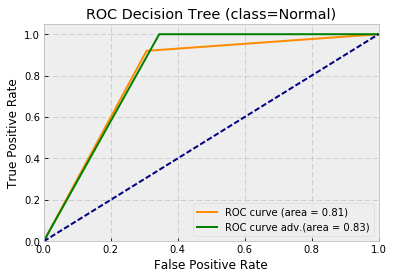

In [17]:
plt.figure()
lw = 2
plt.plot(fpr_dt, tpr_dt, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_dt_adv, tpr_dt_adv, color='green',
         lw=lw, label='ROC curve adv.(area = %0.2f)' % roc_auc_dt_adv)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree (class=Normal)')
plt.legend(loc="lower right")

In [18]:
if FLAGS.nb_classes == 5:
    rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
else:
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
          n_jobs=1)

In [19]:
y_pred = rf.predict(X_test_scaled)

if FLAGS.nb_classes == 5:
    fpr_rf, tpr_rf, _ = roc_curve(y_test.values[:, 0], y_pred[:, 0])
else:
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)

roc_auc_rf = auc(fpr_rf, tpr_rf)
print("Accuracy score", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

Accuracy score 0.739886444287
F1 score: 0.755127857595


In [20]:
# Using adversarial test samples
y_pred_adv = rf.predict(X_adv)

if FLAGS.nb_classes == 5:
    fpr_rf_adv, tpr_rf_adv, _ = roc_curve(y_test.values[:, 0], y_pred_adv[:, 0])
else:
    fpr_rf_adv, tpr_rf_adv, _ = roc_curve(y_test, y_pred_adv)

roc_auc_rf_adv = auc(fpr_rf_adv, tpr_rf_adv)
print("Accuracy score", accuracy_score(y_test, y_pred_adv))
print("F1 score:", f1_score(y_test, y_pred_adv, average='micro'))

Accuracy score 0.740551809794
F1 score: 0.75737207776


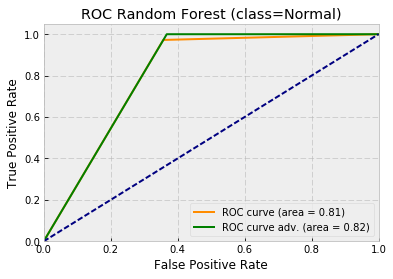

In [21]:
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_rf_adv, tpr_rf_adv, color='green',
         lw=lw, label='ROC curve adv. (area = %0.2f)' % roc_auc_rf_adv)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest (class=Normal)')
plt.legend(loc="lower right")

In [22]:
if FLAGS.nb_classes == 5:
    sv = OneVsRestClassifier(LinearSVC(C=2., random_state=42, loss='hinge'))
else:
    sv = LinearSVC(random_state=42)
sv.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0),
          n_jobs=1)

In [23]:
y_pred = sv.predict(X_test_scaled)

if FLAGS.nb_classes == 5:
    fpr_sv, tpr_sv, _ = roc_curve(y_test.values[:, 0], y_pred[:, 0])
else:
    fpr_sv, tpr_sv, _ = roc_curve(y_test, y_pred)

roc_auc_sv = auc(fpr_sv, tpr_sv)
print("Accuracy score", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy score 0.732434350603
F1 score: 0.722249136543


In [24]:
y_pred_adv = sv.predict(X_adv)

if FLAGS.nb_classes == 5:
    fpr_sv_adv, tpr_sv_adv, _ = roc_curve(y_test.values[:, 0], y_pred_adv[:, 0])
else:
    fpr_sv_adv, tpr_sv_adv, _ = roc_curve(y_test, y_pred)

roc_auc_sv_adv = auc(fpr_sv_adv, tpr_sv_adv)
print("Accuracy score", accuracy_score(y_test, y_pred_adv))
print("F1 score:", f1_score(y_test, y_pred_adv, average='weighted'))

Accuracy score 0.63125443577
F1 score: 0.678913411196


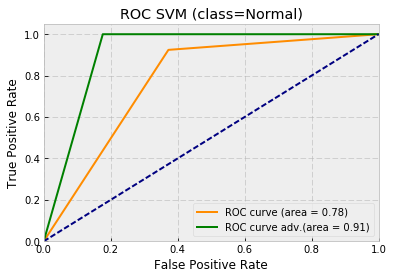

In [25]:
plt.figure()
lw = 2
plt.plot(fpr_sv, tpr_sv, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_sv)
plt.plot(fpr_sv_adv, tpr_sv_adv, color='green',
         lw=lw, label='ROC curve adv.(area = %0.2f)' % roc_auc_sv_adv)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC SVM (class=Normal)')
plt.legend(loc="lower right")

In [26]:
labels = full.label.unique()
le = LabelEncoder()
le.fit(labels)
y_full = le.transform(full.label)
y_train_l = y_full[0:df.shape[0]]
y_test_l = y_full[df.shape[0]:]
print(y_train_l.shape, y_test_l.shape)

(125973,) (22544,)


In [27]:
lr = LogisticRegression(C=1e-4, penalty='l2', max_iter=100,
                        random_state=42,
                        solver='lbfgs',
                        multi_class='ovr')
lr.fit(X_train_scaled, y_train_l)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [54]:
y_pred = lr.predict(X_test_scaled)
fpr_lr, tpr_lr, _ = roc_curve(y_test_l, y_pred, pos_label=1, drop_intermediate=False)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("LR normal accuracy", accuracy_score(y_test_l, y_pred))
print("F1 score:", f1_score(y_test_l, y_pred, average='micro'))

LR normal accuracy 0.655695528744
F1 score: 0.655695528744


In [55]:
y_pred_adv = lr.predict(X_adv)
fpr_lr_adv, tpr_lr_adv, _ = roc_curve(y_test_l, y_pred_adv, pos_label=1, drop_intermediate=False)
roc_auc_lr_adv = auc(fpr_lr_adv, tpr_lr_adv)
print("LR adv. accuracy:", accuracy_score(y_test_l, y_pred_adv))
print("F1 score:", f1_score(y_test_l, y_pred_adv, average='micro'))

LR adv. accuracy: 0.656050390348
F1 score: 0.656050390348


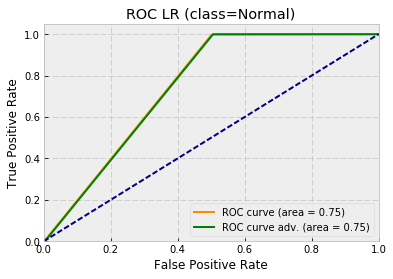

In [56]:
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_lr_adv, tpr_lr_adv, color='green',
         lw=lw, label='ROC curve adv. (area = %0.2f)' % roc_auc_lr_adv)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC LR (class=Normal)')
plt.legend(loc="lower right")

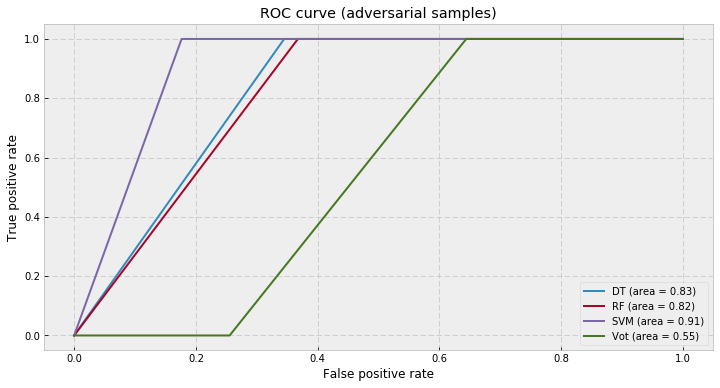

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(fpr_dt_adv, tpr_dt_adv, label='DT (area = %0.2f)' % auc(fpr_dt_adv, tpr_dt_adv))
plt.plot(fpr_rf_adv, tpr_rf_adv, label='RF (area = %0.2f)' % roc_auc_rf_adv)
plt.plot(fpr_sv_adv, tpr_sv_adv, label='SVM (area = %0.2f)' % roc_auc_sv_adv)
#plt.plot(fpr_lr_adv, tpr_lr_adv, label='LR (area = %0.2f)' % roc_auc_lr_adv)
plt.plot(fpr_vot_adv, tpr_vot_adv, label='Vot (area = %0.2f)' % roc_auc_vot_adv)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (adversarial samples)')
plt.legend(loc='best')
plt.savefig('ROC_curves_adv.png')

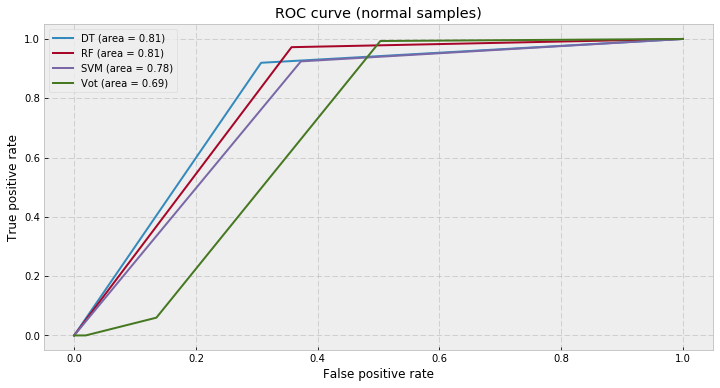

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(fpr_dt, tpr_dt, label='DT (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, label='RF (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_sv, tpr_sv, label='SVM (area = %0.2f)' % roc_auc_sv)
#plt.plot(fpr_lr, tpr_lr, label='LR (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_vot, tpr_vot, label='Vot (area = %0.2f)' % roc_auc_vot)


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (normal samples)')
plt.legend(loc='best')
plt.savefig('ROC_curves.png')

In [60]:
vot = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('sv', sv)], voting='hard')
vot.fit(X_train_scaled, y_train_l)

VotingClassifier(estimators=[('dt', OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
  ...multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0),
          n_jobs=1))],
         n_jobs=1, voting='hard', weights=None)

In [61]:
y_pred = vot.predict(X_test_scaled)
fpr_vot, tpr_vot, _ = roc_curve(y_test_l, y_pred, pos_label=1, drop_intermediate=False)
roc_auc_vot = auc(fpr_vot, tpr_vot)
print("LR normal accuracy", accuracy_score(y_test_l, y_pred))
print("F1 score:", f1_score(y_test_l, y_pred, average='micro'))

LR normal accuracy 0.754790631654
F1 score: 0.754790631654


In [62]:
y_pred_adv = vot.predict(X_adv)
fpr_vot_adv, tpr_vot_adv, _ = roc_curve(y_test_l, y_pred_adv, pos_label=1, drop_intermediate=False)
roc_auc_vot_adv = auc(fpr_vot_adv, tpr_vot_adv)
print("LR adv. accuracy:", accuracy_score(y_test_l, y_pred_adv))
print("F1 score:", f1_score(y_test_l, y_pred_adv, average='micro'))

LR adv. accuracy: 0.707194819021
F1 score: 0.707194819021


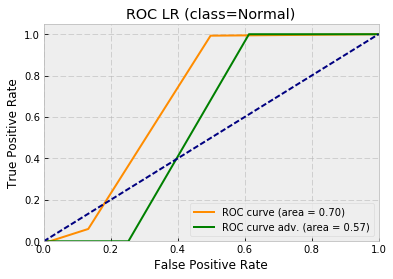

In [63]:
plt.figure()
lw = 2
plt.plot(fpr_vot, tpr_vot, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_vot)
plt.plot(fpr_vot_adv, tpr_vot_adv, color='green',
         lw=lw, label='ROC curve adv. (area = %0.2f)' % roc_auc_vot_adv)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC LR (class=Normal)')
plt.legend(loc="lower right")

In [56]:
# Comparison of adversarial and original test samples (attack)
feats = dict()
total = 0
orig_attack = X_test_scaled1 - X_adv
for i in range(0, orig_attack.shape[0]):
    #if y_test_bin[i] == 1:
    #    continue
    ind = np.where(orig_attack[i, :] != 0)[0]
    total += len(ind)
    for j in ind:
        if j in feats:
            feats[j] += 1
        else:
            feats[j] = 1
    #print(ind, X_test.columns[ind])

In [57]:
# The number of features that where changed for the adversarial samples
print("Number of unique features changed:", len(feats.keys()))
print("Number of average features changed per datapoint", total/len(orig_attack))

Number of unique features changed: 66
Number of average features changed per datapoint 7.611914478353442


In [58]:
top_10 = sorted(feats, key=feats.get, reverse=True)[:10]
top_20 = sorted(feats, key=feats.get, reverse=True)[:20]

In [59]:
feats

{0: 424,
 1: 9549,
 2: 8967,
 4: 1212,
 6: 68,
 7: 5,
 8: 10214,
 9: 18,
 10: 18,
 11: 3,
 12: 7,
 13: 6,
 15: 52,
 18: 75,
 19: 9710,
 20: 9710,
 21: 95,
 22: 120,
 23: 84,
 24: 98,
 25: 11427,
 26: 5938,
 27: 3708,
 28: 9710,
 29: 13174,
 30: 15493,
 31: 6865,
 32: 6308,
 33: 4845,
 34: 460,
 35: 295,
 36: 742,
 37: 311,
 38: 93,
 39: 7842,
 40: 1776,
 41: 4250,
 42: 4,
 45: 19,
 53: 6848,
 55: 26,
 56: 48,
 59: 47,
 60: 48,
 61: 320,
 65: 7671,
 74: 1,
 84: 65,
 85: 537,
 88: 8,
 90: 852,
 92: 1,
 95: 618,
 101: 44,
 102: 1,
 103: 1,
 104: 5,
 106: 738,
 112: 200,
 113: 2,
 114: 1,
 115: 44,
 117: 163,
 118: 8,
 119: 4,
 120: 9607}

In [60]:
X_test.columns[top_10]

Index(['dst_host_same_srv_rate', 'dst_host_srv_count', 'same_srv_rate',
       'logged_in', 'count', 'srv_count', 'dst_host_count', 'flag_SF',
       'src_bytes', 'dst_bytes'],
      dtype='object')

In [61]:
X_test.columns[top_20]

Index(['dst_host_same_srv_rate', 'dst_host_srv_count', 'same_srv_rate',
       'logged_in', 'count', 'srv_count', 'dst_host_count', 'flag_SF',
       'src_bytes', 'dst_bytes', 'protocol_tcp', 'service_http',
       'dst_host_diff_srv_rate', 'service_domain_u',
       'dst_host_same_src_port_rate', 'diff_srv_rate',
       'dst_host_srv_diff_host_rate', 'service_IRC', 'srv_diff_host_rate',
       'protocol_udp'],
      dtype='object')

In [62]:
top_10_val = [100*feats[k] / y_test.shape[0] for k in top_10]
top_20_val = [100*feats[k] / y_test.shape[0] for k in top_20]
top_20_val

[68.72338537970191,
 58.43683463449255,
 50.687544357700496,
 45.3069552874379,
 43.07132718239887,
 43.07132718239887,
 43.07132718239887,
 42.61444286728176,
 42.35716820440028,
 39.77555003548616,
 34.78530872959546,
 34.026792051100074,
 30.45156139105749,
 30.376153300212916,
 27.980837473385378,
 26.339602555003548,
 21.491305890702627,
 18.852022711142656,
 16.447835344215754,
 7.877927608232789]

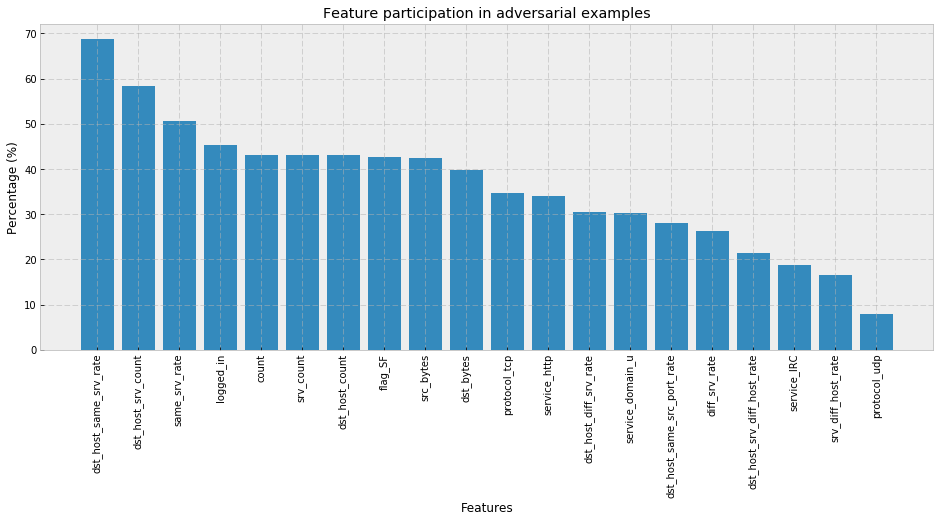

In [63]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(20), top_20_val, align='center')
plt.xticks(np.arange(20), X_test.columns[top_20], rotation='vertical')
plt.title('Feature participation in adversarial examples')
plt.ylabel('Percentage (%)')
plt.xlabel('Features')
plt.savefig('Adv_features.png')

In [54]:
# Craft adversarial examples using Fast Gradient Sign Method (FGSM)
adv_x_f = fgsm(x, predictions, eps=0.3)
X_test_adv, = batch_eval(sess, [x], [adv_x_f], [X_test_scaled1])

# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions, X_test_adv, y_test)
print('Test accuracy on adversarial examples: ' + str(accuracy))



/media/marik0/experiments/data/security/KDD-NSL/cleverhans/utils_tf.py:34: UserWarning: Setting parameters (batch_size) from TensorFlow FLAGS is deprecated.
  'deprecated.'.format(name))


Batch 100
Batch 100
Test accuracy on adversarial examples: 0.0861870120653


In [56]:
# Comparison of adversarial and original test samples (attack)
feats = dict()
total = 0
orig_attack = X_test_scaled1 - X_test_adv
for i in range(0, orig_attack.shape[0]):
    #if y_test_bin[i] == 1:
    #    continue
    ind = np.where(orig_attack[i, :] != 0)[0]
    total += len(ind)
    for j in ind:
        if j in feats:
            feats[j] += 1
        else:
            feats[j] = 1

In [57]:
# The number of features that where changed for the adversarial samples
print("Number of unique features changed:", len(feats.keys()))
print("Number of average features changed per datapoint", total/len(orig_attack))

Number of unique features changed: 122
Number of average features changed per datapoint 122.0


In [67]:
y_train.head()

label_normal  label_dos  label_probe  label_r2l  label_u2r
0             1          0            0          0          0
1             1          0            0          0          0
2             0          1            0          0          0
3             1          0            0          0          0
4             1          0            0          0          0